In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn import preprocessing
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import nltk
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [3]:
df.isnull().sum()

tweets    0
label     0
dtype: int64

In [4]:
# Se tiver valores nulos, usar o código abaixo

# df = df[~df['label'].isnull()]
# df

In [5]:
df1 = df["tweets"]
df2 = df["label"]

In [6]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


tweets_tratados = df1.apply(cleanTxt)
tweets_tratados = tweets_tratados.apply(removeEmojis)
tweets_tratados = tweets_tratados.apply(removeStopWords)
tweets = list(tweets_tratados)

In [7]:
tweets_tratados.isnull().sum()

0

In [8]:
label_encoder = preprocessing.LabelEncoder()
labels = pd.DataFrame(label_encoder.fit_transform(df2), columns=["Label"], index = df.index)
labels

,Label
0,2
1,1
2,1
3,1
4,0
...,...
18104,2
18105,2
18106,0
18107,3


In [9]:
labels.value_counts()

Label
2        8385
1        4819
3        2961
0        1944
dtype: int64

In [10]:
from keras.utils.np_utils import to_categorical
y = to_categorical(labels)

In [38]:
y.shape

(18109, 4)

In [12]:
# preparar tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [13]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11579 unique tokens.


In [14]:
# integer codificar os documentos
sequences = tokenizer.texts_to_sequences(tweets)

In [15]:
# preencher documentos com um comprimento máximo de 28 palavras
maxlen = 28
X = pad_sequences(sequences, maxlen=maxlen)

In [16]:
X.shape

(18109, 28)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12676, 28), (5433, 28), (12676, 4), (5433, 4))

In [19]:
# SimpleRNN
vocab_size = len(word_index) + 1
output_dim = 32
maxlen = maxlen
model = Sequential()
model.add(Embedding(vocab_size, output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 32)            370560    
                                                                 
 simple_rnn (SimpleRNN)      (None, 28, 32)            2080      
                                                                 
 dropout (Dropout)           (None, 28, 32)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 28, 32)            2080      
                                                                 
 dropout_1 (Dropout)         (None, 28, 32)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 4)                 1

In [21]:
model.save('srnn.h5')

In [22]:
start = time.time()

# Ajustar o modelo ao conjunto de treino
rnn_hist = model.fit(X_train, y_train, epochs=3, validation_split=0.3)
# Avaliação final do modelo
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/3
278/278 [==============================] - 13s 30ms/step - loss: 0.9528 - accuracy: 0.6325 - val_loss: 0.8006 - val_accuracy: 0.7071
Epoch 2/3
278/278 [==============================] - 7s 25ms/step - loss: 0.5809 - accuracy: 0.7965 - val_loss: 0.6449 - val_accuracy: 0.7791
Epoch 3/3
278/278 [==============================] - 7s 25ms/step - loss: 0.3750 - accuracy: 0.8759 - val_loss: 0.6710 - val_accuracy: 0.7796
Accuracy: 78.13%
Training duration(minutes): 0.47935384114583335


In [23]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 28, 32)            370560    
                                                                 
 lstm (LSTM)                 (None, 28, 32)            8320      
                                                                 
 dropout_2 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_3 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 4)                

In [25]:
model.save('lstm.h5')

In [26]:
start = time.time()
# Ajustar o modelo ao conjunto de treino
lstm_hist = model.fit(X_train, y_train, epochs=4, validation_split=0.3)
# avaliação final do modelo
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/4
278/278 [==============================] - 24s 57ms/step - loss: 0.9354 - accuracy: 0.6302 - val_loss: 0.7573 - val_accuracy: 0.7152
Epoch 2/4
278/278 [==============================] - 13s 45ms/step - loss: 0.6234 - accuracy: 0.7649 - val_loss: 0.6649 - val_accuracy: 0.7512
Epoch 3/4
278/278 [==============================] - 13s 46ms/step - loss: 0.4759 - accuracy: 0.8371 - val_loss: 0.6226 - val_accuracy: 0.7828
Epoch 4/4
278/278 [==============================] - 12s 45ms/step - loss: 0.3948 - accuracy: 0.8697 - val_loss: 0.6500 - val_accuracy: 0.7768
Accuracy: 78.59%
Training duration(minutes): 1.0631240526835124


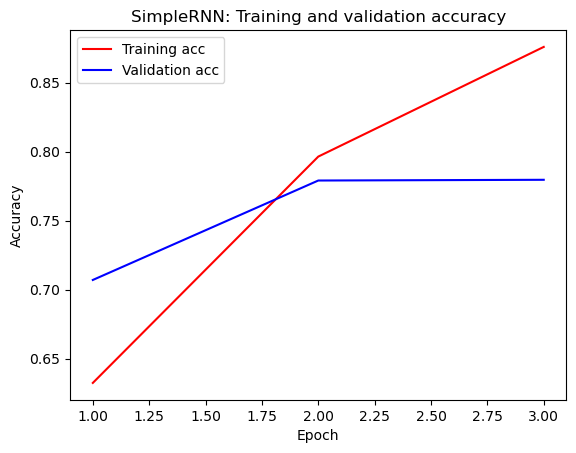

In [27]:
# SimpleRNN Result

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('SimpleRNN: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

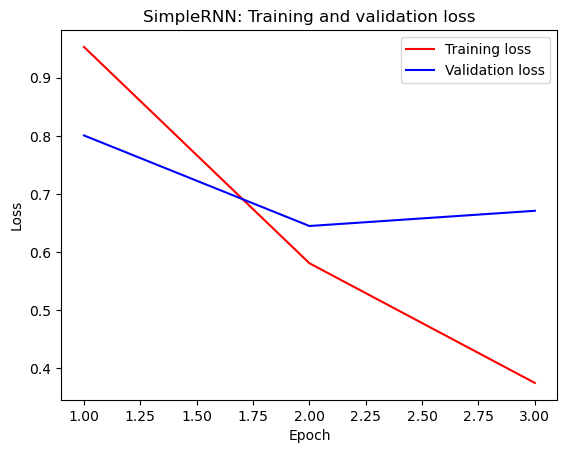

In [28]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('SimpleRNN: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

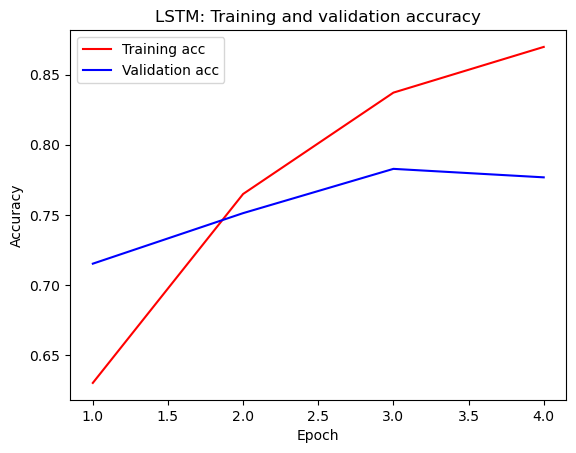

In [29]:
# LSTM Result

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

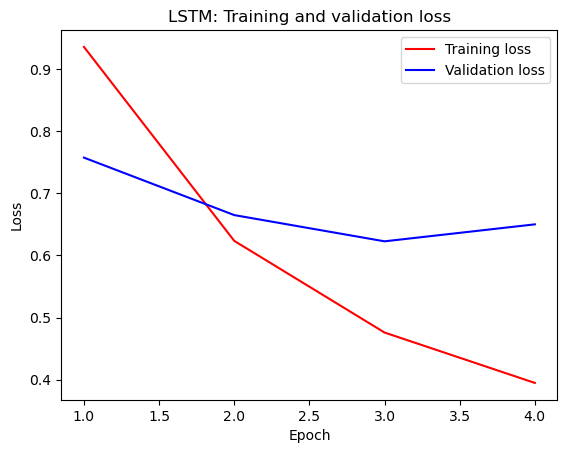

In [30]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

In [31]:
from keras.models import load_model
lstm = load_model('lstm.h5')
warnings.filterwarnings("ignore")

In [32]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 28, 32)            370560    
                                                                 
 lstm (LSTM)                 (None, 28, 32)            8320      
                                                                 
 dropout_2 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_3 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 4)                

In [33]:
predictions = lstm.predict(X_test)

170/170 [==============================] - 4s 13ms/step
